In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [42]:
def subplot(rows_count, column_count, images, titles):
    for i in range(len(images)):
        plt.subplot(rows_count, column_count, i+1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray')


6.1.1. Convert Lena to HSI format, and display the HIS components as separate grayscale images. Observe these images to comment on what does each of the H, S, I components represent. The HSI images should be saved in double precision.

In [11]:
lena = cv2.imread('./Images/Lena.bmp')

In [12]:
def RGB_TO_HSI(img):

    with np.errstate(divide='ignore', invalid='ignore'):

        #Load image with 32 bit floats as variable type
        bgr = np.float32(img)/255

        #Separate color channels
        blue = bgr[:,:,0]
        green = bgr[:,:,1]
        red = bgr[:,:,2]

        #Calculate Intensity
        def calc_intensity(red, blue, green):
            return np.divide(blue + green + red, 3)

        #Calculate Saturation
        def calc_saturation(red, blue, green):
            minimum = np.minimum(np.minimum(red, green), blue)
            saturation = 1 - (3 / (red + green + blue + 0.001) * minimum)

            return saturation

        #Calculate Hue
        def calc_hue(red, blue, green):
            hue = np.copy(red)

            for i in range(0, blue.shape[0]):
                for j in range(0, blue.shape[1]):
                    hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                                math.sqrt((red[i][j] - green[i][j])**2 +
                                        ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
                    hue[i][j] = math.acos(hue[i][j])

                    if blue[i][j] <= green[i][j]:
                        hue[i][j] = hue[i][j]
                    else:
                        hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]

            return hue

        #Merge channels into picture and return image
        hsi = cv2.merge((calc_hue(red, blue, green), calc_saturation(red, blue, green), calc_intensity(red, blue, green)))
        return hsi

In [15]:
# convert Lena image from RGB to HSI
lena_in_HSI = RGB_TO_HSI(lena)

# find each H, S and I component of lena image
lena_hue = lena_in_HSI[:, :, 0]
lena_saturation = lena_in_HSI[:, :, 1]
lena_intensity = lena_in_HSI[:, :, 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


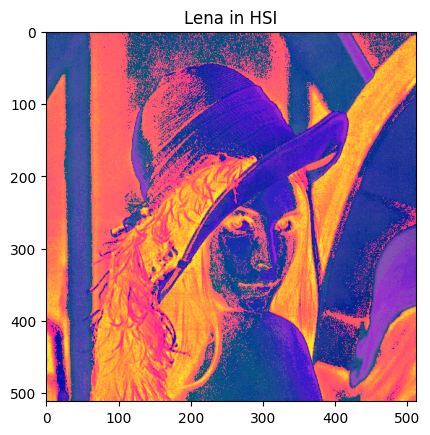

In [40]:
plt.imshow(lena_in_HSI)
plt.title('Lena in HSI')
plt.show()

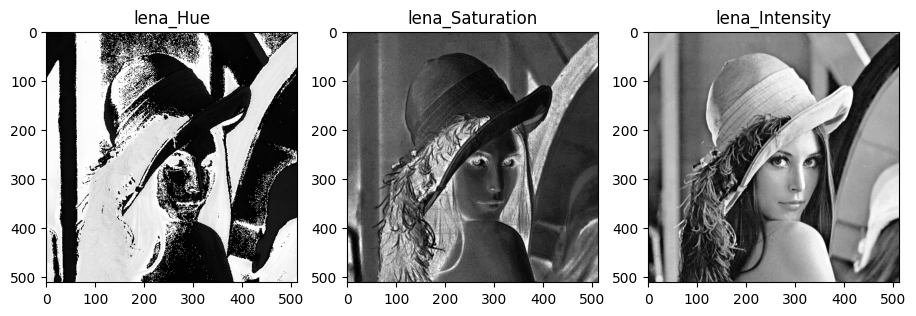

In [44]:
plt.figure(figsize=(11, 4))
subplot(1, 3,
        [lena_hue, lena_saturation, lena_intensity],
        ['lena_Hue', 'lena_Saturation', 'lena_Intensity'])
